<a href="https://colab.research.google.com/github/kkrusere/Market-Basket-Analysis-on-the-Online-Retail-Data/blob/main/MBA_Online-Retail_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## <center> **Market Basket Analysis on Online Retail Data** 
<center><em>Providing a Retail Business with a strategy which helps improve their product sales, inventory management, and customer retention, which in turn would improve the profitability of the business.</em></center>
<br>
<center><img src="https://github.com/kkrusere/Market-Basket-Analysis-on-the-Online-Retail-Data/blob/main/Assets/MBA.jpg?raw=1" width=600/></center>

***Project Contributors:*** Kuzi Rusere<br>
**MBA streamlit App URL:** https://kkrusere-market-basket-analysis-on-the-online-re-mba-app-oi5iot.streamlitapp.com/

### **Project Introduction**

***Business Proposition:*** This project aims to provide a Retail Business with a strategy that helps improve their product sales, inventory management, and customer retention, which in turn would improve the profitability of the business. In the retail environment, profitability and the `bottom line` is at the focal point of any organization or business in this space. From product sales, through inventory management to customer acquisition and retention all this one way or the other affects the business' profits and net revenue. Transaction data from the POS (point of sale) systems for a retail business is a treasure trove of insights that can be used to better understand the products, customer purchase behavior, and sales together with the relationship and patterns in between. This project explores the different ways of deriving these insights, patterns, and relationships, and how these can be used in designing, developing, and implementing a strategy to improve the retail business' profits, revenue, and overall operations<br>
<br><br>

***Methodology:*** Data Mining, Analysis and Visualization of Retail Sales Data.<br>
1. Market Basket Analysis (MBA), which aims to find relationship and establishing pattens within the retail sales data. <br>
2. Customer Segmentation 
> * RFM (recency, frequency, monetary) Analysis
> * Cohort analysis
3. Product Recomendation (people who bought this also bought)

In addition, <br>
We create a `Streamlit` interactive data visualization tool that allows users interact with the data and analytics.

### **Data Collection**


In [50]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display, HTML

import calendar
import datetime as dt

import re

In [51]:
#we are going to import the data into a pandas dataframe 
def data_loading(path):
    """
    This function reads the Excel data file from UCI Machinelearning repository 
    The data is stored into a pandas dataframe that the fuction returns  
    """
    df = pd.read_excel(path)
    return df

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

df = data_loading(data_url)

**General Information About the Data** <br>
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. <br>

**Information about the Attributes/Columns in the Dataset** <br>

***InvoiceNo:*** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>

***StockCode:*** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>

***Description:*** Product (item) name. Nominal. <br>

***Quantity:*** The quantities of each product (item) per transaction. Numeric.<br>

***InvoiceDate:*** Invice Date and time. Numeric, the day and time when each transaction was generated. <br>

***UnitPrice:*** Unit price. Numeric, Product price per unit in sterling.<br>

***CustomerID:*** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>

***Country:*** Country name. Nominal, the name of the country where each customer resides. <br>

In [52]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We are going to use the pandas '.shape' function/method to the total number of columns and rows of the dataframe. We can see that our dataframe contains 541909 rows and 8 columns

In [53]:
df.shape

(541909, 8)

We'll use the pandas '.info()' function so see the general infomation (data types, null value count, etc.) about the data.

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From the above we can see that the Description and CustomerID columns have null values, and that the CustomerID has data type float64. 
> * We are going to convert the CustomerID datatype to 'string' and ***Consider*** the null values in this columns ***Guest Customer*** implying that they are customers that do not have Customer IDs.<br> <br>
> * For the null values in the Description column, we are also going to delete the rows, since we do not have any use of them in this particular project.

### **Data Cleaning and Preparation**

We are going to create a function that will encompass all the cleaning and manipulation/modifications that we are going to do to the data.

**What we are going to do to the data frame:**<br>
* Changing the CustomerID to dtype 'object' and replace the null values to 'Guest Customer'.<br><br>
* Remove the rows that have null values from the Description column. we are also going to remove rows that have a product description that has a length less than or equal to 6 characters, this is because the description is not actually products (well from our understanding). Below is a sample of some of these descriptions 
> ['wet?','Damaged','Missing','Discount','lost','MIA','SAMPLES','Display','mailout ','?','missing?','broken','lost??','CARRIAGE','mouldy','smashed']
* Cancelled orders will be removed, since as per the info about the attributes/columns of our dataset, for the 'InvoiceNo' the entries that contain a 'c' is a canceled orders.<br><br>
* We are going to remove the data entries from 2010 and then split the 'Invoice Date' column into just Date (without the time), Time, Month, Day, Week, Day of the Week, Hour, Time of Day (which is either Morning, Afternoon or Evening). We are going to need these to dissect the transactions at different periods.<br><br>
* We are also going to remove and consolidate duplicated entries in the product description that have the same `stockcode`
* A 'Sales Revenue' column will be created by multiplying the 'Quantity' and 'UnitPrice' columns. This will give the monetary value of each data entry.


In [55]:
def data_cleaning_and_prep(df):
    """  
    This is the Data Cleaning and Preperation Function
    It takes in a dataframe, does the data cleaning and prep and returns dataframe
    """
    ######*****CustomerID column******###########
    #replacing the nan with 'Guest Customer' so that we can convert to int to remove the decimal point
    df["CustomerID"] = df["CustomerID"].fillna(0)
    df["CustomerID"] = df["CustomerID"].astype(int)
    df["CustomerID"] = df["CustomerID"].astype(str)
    df["CustomerID"] = df["CustomerID"].replace('0','Guest Customer')

    ######*****InvoiceDate column******###########
    df['Date'] = df['InvoiceDate'].dt.date
    df['Month'] = df['InvoiceDate'].dt.month
    df['Year'] = df['InvoiceDate'].dt.year
    #we change the number month to the actual name of the month 
    df['Month'] = df['Month'].apply(lambda x: calendar.month_name[int(x)])
    df['Week of the Year'] = df['InvoiceDate'].dt.isocalendar().week
    #we will add the day of the week to the dataframe 
    df['Day of Week'] = df['InvoiceDate'].dt.day_name()
    df['Time'] = df['InvoiceDate'].dt.time
    df["Hour"] = df['InvoiceDate'].dt.hour
    df['Time of Day']=pd.cut(df['InvoiceDate'].dt.hour,[0,6,12,18,23],labels=['Night','Morning','Afternoon','Evening'],include_lowest=True)
    #lastly here, we will drop the row from the year 2010
    index_names = df[df['Year'] == 2010].index
    df.drop(index_names, inplace = True)
    df.drop('Year', axis=1, inplace=True)

    ######*****InvoiceNo column******#############
    #now we drop the row with cancelled orders
    df['InvoiceNo'] = df['InvoiceNo'].dropna()

    #####*****Sales Revenue column******##########
    #we'll create a column called 'Sales Revenue' = 'Quantity' multiplied by 'UnitPrice'
    df['Sales Revenue'] = df['UnitPrice'] * df['Quantity']

    #####*****Country column******##########
    #we are going to drop the rows that have "Unspecified" country
    df.drop(df[df["Country"] == "Unspecified"].index, inplace = True)

    ###drop row were the quantity and sales revenue that is less than 0 and drop duplicated rows if any
    index_names = df[df['Quantity'] <= 0].index
    df.drop(index_names, inplace = True)
    index_names = df[df['Sales Revenue'] <= 0].index
    df.drop(index_names, inplace = True)
    df.drop_duplicates(inplace = True)

    ######*****Description column******###########
    #dropping the nan from the Description column
    df.dropna(subset = ['Description'], inplace= True)
    #removing the descriptions with lenth less than or equal to 8 characters
    df.drop(df[df.Description.str.len() <= 8].index, inplace=True)
    #we are going to drop this special case row with description '20713' at index '417090'
    df.drop(df.index[417090], inplace=True)
    #the description to lower case
    df.Description = df.Description.str.lower()
    #we are also going to remove the row that have description value "dotcom postage"
    index_names = df[ df['Description'] == "dotcom postage" ].index
    # drop these row indexes
    # from dataFrame
    df.Description = df.Description.str.upper()
    df["Description"] = df["Description"].str.strip()
    df.drop(index_names, inplace = True)
    #getting rid of the duplicated product discription
    the_dict = dict()
    df.reset_index(drop=True, inplace=True)
    for i, code in enumerate(df["StockCode"]):
        if code not in the_dict:
            the_dict[code] = list()
        if df["Description"][i] not in the_dict[code]:
            the_dict[code].append(df["Description"][i])

    dict_to_look_at = dict()
    for key in the_dict:
        if len(the_dict[key]) > 1:
            dict_to_look_at[key] = the_dict[key]

    key_list = list(dict_to_look_at.keys())
    for key_l in key_list:
        x = dict_to_look_at[key_l]
        max_len = 0
        index = 0
        for i in range(len(x)):
            if len((x[i]).split()) >= max_len:
                max_len = len((x[i]).split())
                index = i
        dict_to_look_at[key_l] = x[index]

    for key in dict_to_look_at:
        df.loc[df["StockCode"] == key, "Description"] = dict_to_look_at[key]

    return df

df = data_cleaning_and_prep(df)

After cleaning the data we are left with 481313 and now have 16 columns. 

In [56]:
df.shape

(481313, 16)

In [57]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Month,Week of the Year,Day of Week,Time,Hour,Time of Day,Sales Revenue
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,19.5
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,12.5


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481313 entries, 0 to 481312
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         481313 non-null  object        
 1   StockCode         481313 non-null  object        
 2   Description       481313 non-null  object        
 3   Quantity          481313 non-null  int64         
 4   InvoiceDate       481313 non-null  datetime64[ns]
 5   UnitPrice         481313 non-null  float64       
 6   CustomerID        481313 non-null  object        
 7   Country           481313 non-null  object        
 8   Date              481313 non-null  object        
 9   Month             481313 non-null  object        
 10  Week of the Year  481313 non-null  UInt32        
 11  Day of Week       481313 non-null  object        
 12  Time              481313 non-null  object        
 13  Hour              481313 non-null  int64         
 14  Time

In [59]:
df.describe()

,Quantity,UnitPrice,Week of the Year,Hour,Sales Revenue
count,481313.00000,481313.000000,481313.000000,481313.000000,481313.000000
mean,10.80504,3.252614,29.164677,13.066221,19.693793
std,162.79915,16.522079,14.743237,2.448566,280.999991
min,1.00000,0.001000,1.000000,6.000000,0.001000
25%,1.00000,1.250000,16.000000,11.000000,3.900000
50%,4.00000,2.080000,31.000000,13.000000,9.950000
75%,12.00000,4.130000,43.000000,15.000000,17.700000
max,80995.00000,11062.060000,49.000000,20.000000,168469.600000


At this point, we load the clean data using the function above. We are also going to save the data to our AWS RDS MySQL database for later use in the Streamlit application of this project.

In [60]:
# import mysql.connector as connection
# from sqlalchemy import create_engine
# import config

# host=config.host
# user=config.user
# password=config.password
# port = config.port

# conn = connection.connect(
#   host=host,
#   user=user,
#   password=password,
#   port = port,
# )
# mycursor = conn.cursor()

# database = config.database

# mycursor.execute(f"CREATE DATABASE IF NOT EXISTS {database}")

# mycursor.execute("SHOW DATABASES")

# # create sqlalchemy engine
# engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")
# df.to_sql('MBA_Online-Retail_Data', con = engine, if_exists = 'append', index=False)

### **Exploratory Data Analysis *(EDA)***

* Exploratory data analysis is an approach/practice of analyzing data sets to summarize their main characteristics, often using statistical graphics and other ***data visualization***. It is a critical process of performing initial ***investigations to discover*** patterns, detect outliers and anomalies, and gain some new, hidden, insights into the data.

* Investigating questions like the total volume of purchases per month, week, day of the week, time of the day right to the hour. We will look at customers more later when we get into the ***Recency, Frequency and Monetary Analysis (RFM)***, ***Cohort analysis***, and the ***Customer Profitability Analysis (CPA)*** sections of the project.

We are going to create a helper fuction that will group the Quantity and Sales Revenue with respect to either the 'CustomerID', 'Country', 'Date', 'Month','Week of the Year', 'Day of Week', 'Hour', or 'Time of Day'.

In [61]:
def group_Quantity_and_SalesRevenue(df,string):
    """ 
    This function inputs the main data frame and feature name 
    The feature name is the column name that you want to group the Quantity and Sales Revenue
    """

    df = df[[f'{string}','Quantity','Sales Revenue']].groupby([f'{string}']).sum().sort_values(by= 'Sales Revenue', ascending = False).reset_index()

    return df

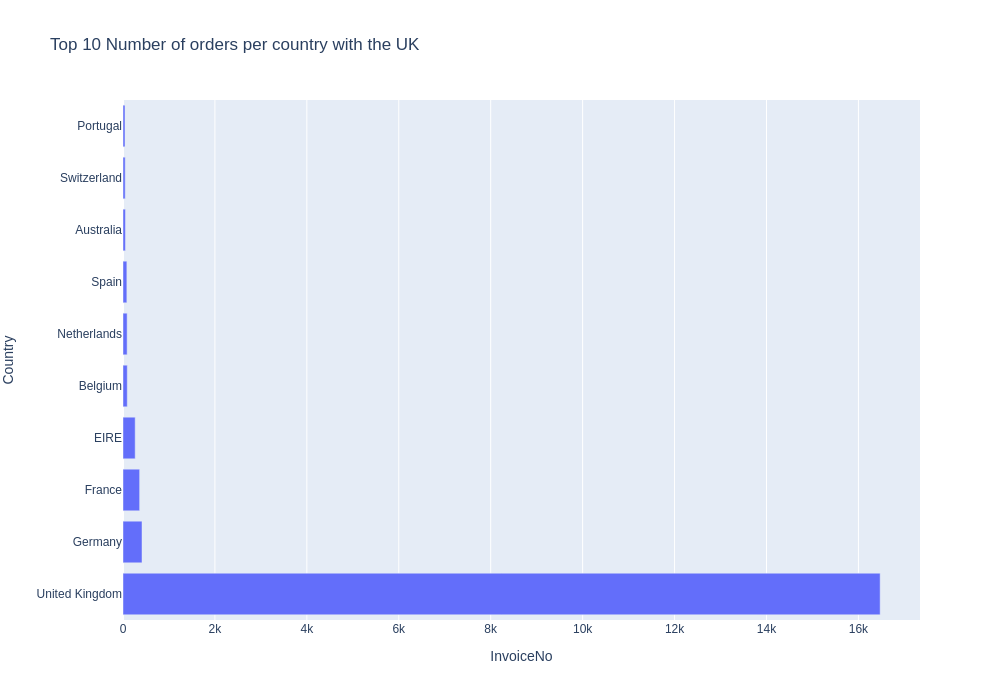

In [62]:
Country_Data = df.groupby("Country")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(10)
fig = px.bar(Country_Data, x= "InvoiceNo", y='Country', title= "Top 10 Number of orders per country with the UK")
fig.show(renderer='png', height=700, width=1000)
#fig.show( height=700, width=1000)

UK has more number of orders witk 16k Invoice numbers 

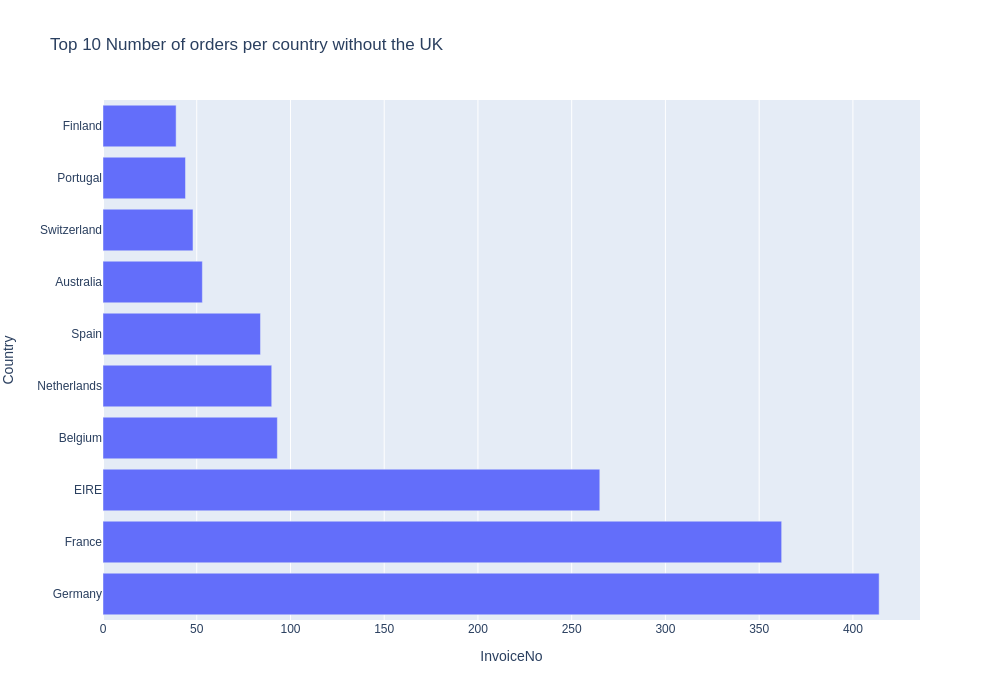

In [63]:
Country_Data = df[df['Country'] != "United Kingdom"].groupby("Country")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(10)
fig = px.bar(Country_Data, x= "InvoiceNo", y='Country', title= "Top 10 Number of orders per country without the UK")
fig.show(renderer='png', height=700, width=1000)
#fig.show( height=700, width=1000)

The above charts show that the UK by far has more invoices, just as suspected, with invoices surpassing 15K. Germany in in second place, with approximately 30 time less invoices. The retail store management can start possing question of why this is the case, especially when this is a Online retail store. Question like, what is the traffic like to the store web page, or should they start thinking of ***Search Engine Optimization (SEO)***, which is the process of improving the quality and quantity of website traffic to a website or a web page from search engines. Many other questions can be raised from the 2 charts above.

We can take a look at how the countries fare up with regards to the ***Quantity sold*** and ***Sales Revenue***.The first plot is going to be for Quantity sold and the second will be for Sales Revenue both for the whole year of 2011.

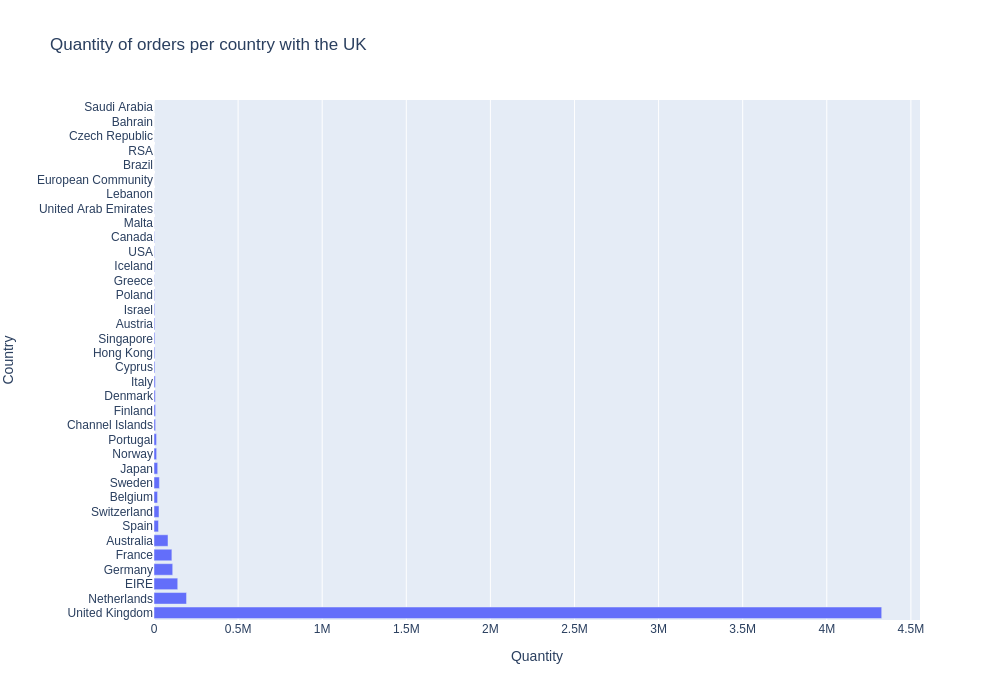

In [64]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df, x= "Quantity", y='Country', title= "Quantity of orders per country with the UK")
fig.show(renderer='png', height=700, width=1000)
#fig.show( height=700, width=1000)

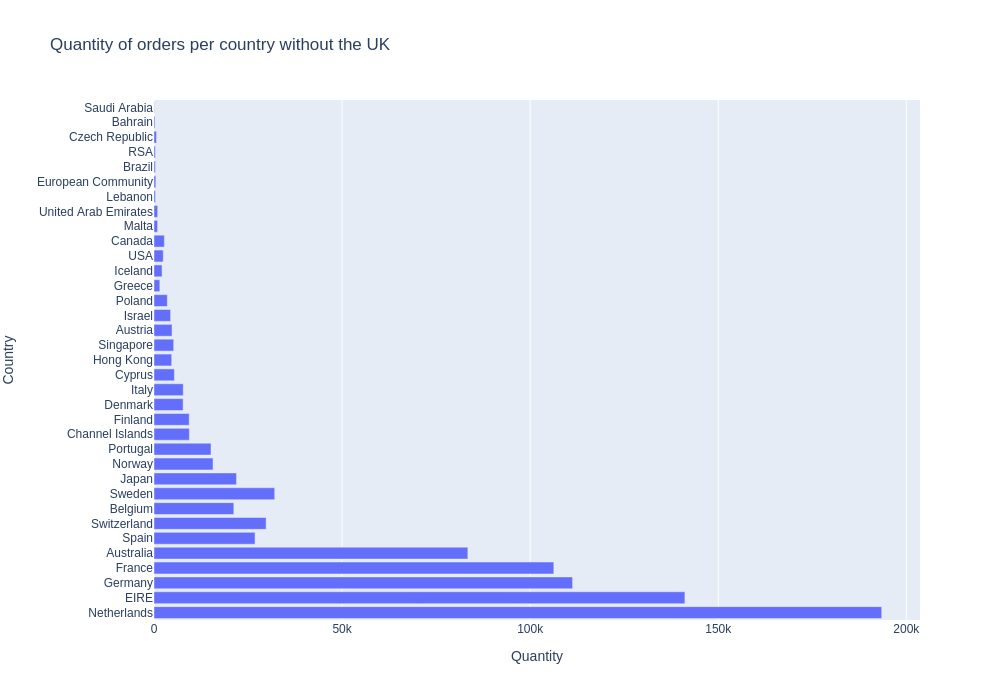

In [65]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df[temp_df['Country'] != "United Kingdom"], x= "Quantity", y='Country', title= "Quantity of orders per country without the UK")
fig.show(renderer='png', height=700, width=1000)
#fig.show( height=700, width=1000)

Just as expected, the UK has high volumes of Quantitly sold and the below charts should show that the UK has high sales as well. However, unlike the number of invoices, the Netherlands has the second highest volume of Quantity sold at approximately 200K. 

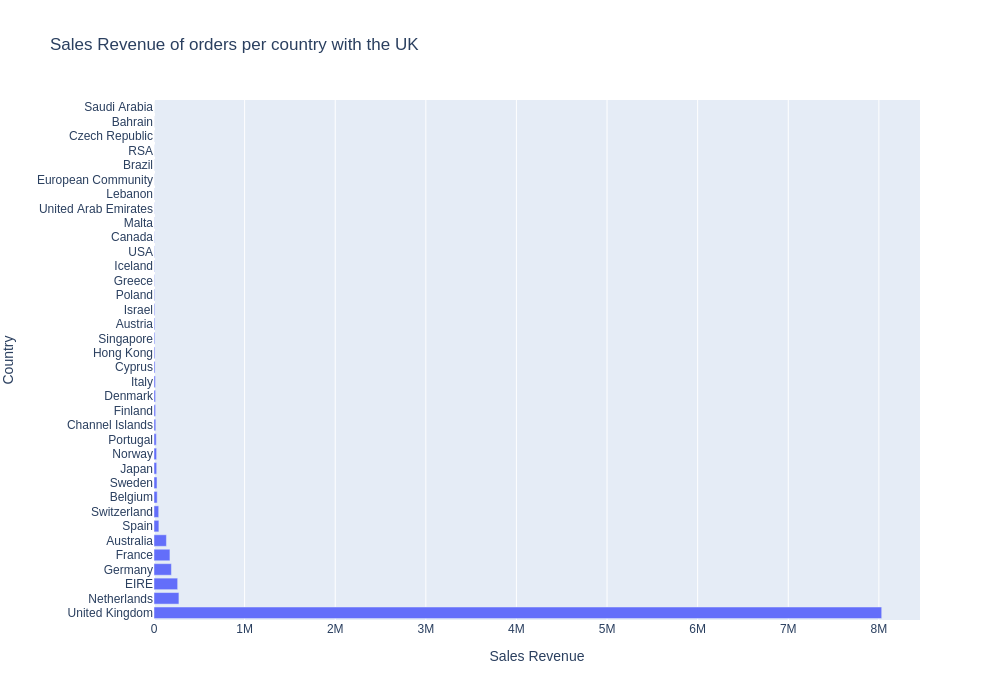

In [66]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df, x= "Sales Revenue", y='Country', title= "Sales Revenue of orders per country with the UK")
fig.show(renderer='png', height=700, width=1000)
#fig.show( height=700, width=1000)

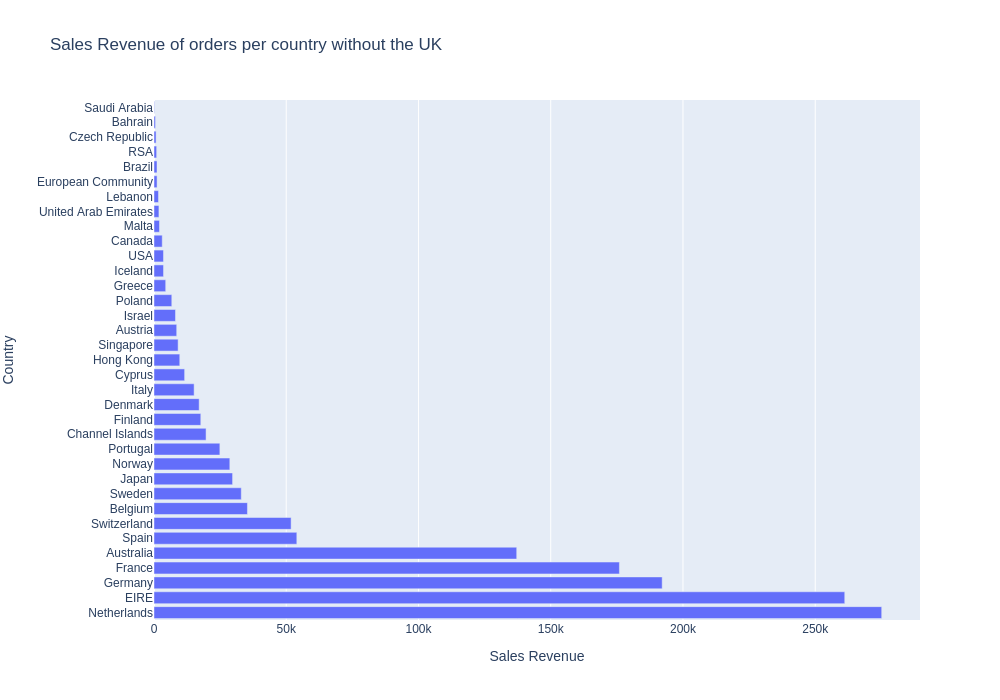

In [67]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df[temp_df['Country'] != "United Kingdom"], x= "Sales Revenue", y='Country', title= "Sales Revenue of orders per country without the UK")
fig.show(renderer='png', height=700, width=1000)
#fig.show( height=700, width=1000)

The sales revenue of Netherlands and Germany is quite close. In the streamlit app of this project, a time filter of this project is used to breakedown by time periods 'Month', 'Week', 'Day of the Week', 'Time of Day' ,or 'Hour'.

We now going to look at the products, which ones have high Quantity sold, or which product has high Sales Revenue. But first the below chart is a wordcloud of the product descriptions. A wordcloud is a visual representations of words that give greater prominence to words that appear more frequently, in this case the frequency is the 'Quantity'

In [68]:
def wordcloud_of_Description(df, title):
    """
    This fuction creates a word cloud
    inputs a data frame converts it to tuples and uses the input 'title' as the title of the word cloud
    """
    plt.rcParams["figure.figsize"] = (20,20)
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()


def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

We can create a word cloud of the Product Descriptions per Quantity

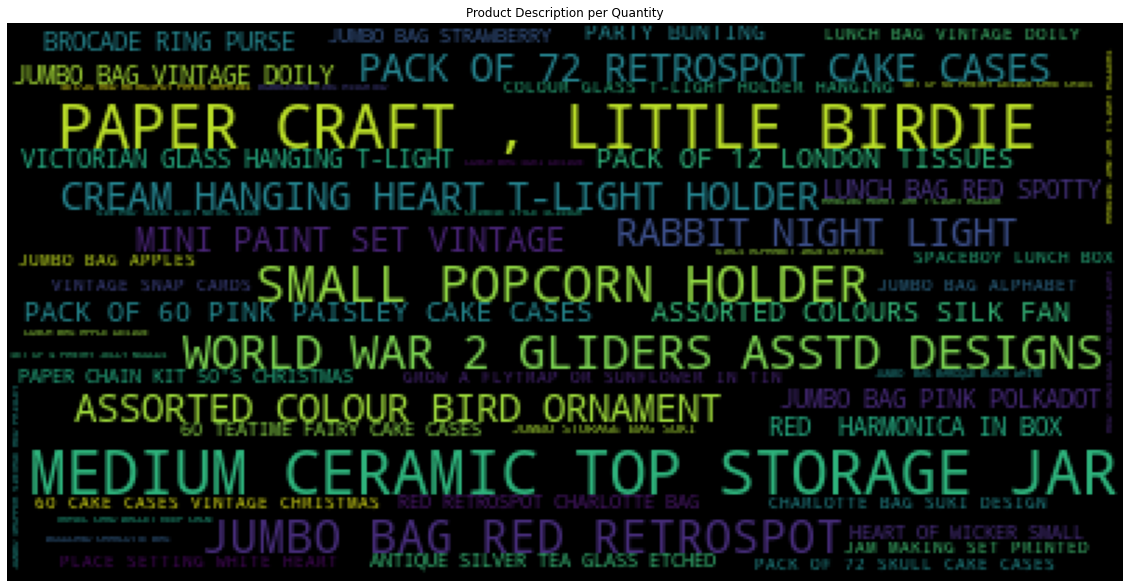

In [69]:
temp_df = pd.DataFrame(df.groupby('Description')['Quantity'].sum()).reset_index()
title = "Product Description per Quantity"
wordcloud_of_Description(temp_df, title)

We can create a word cloud of the Product Descriptions per Sales Revenue

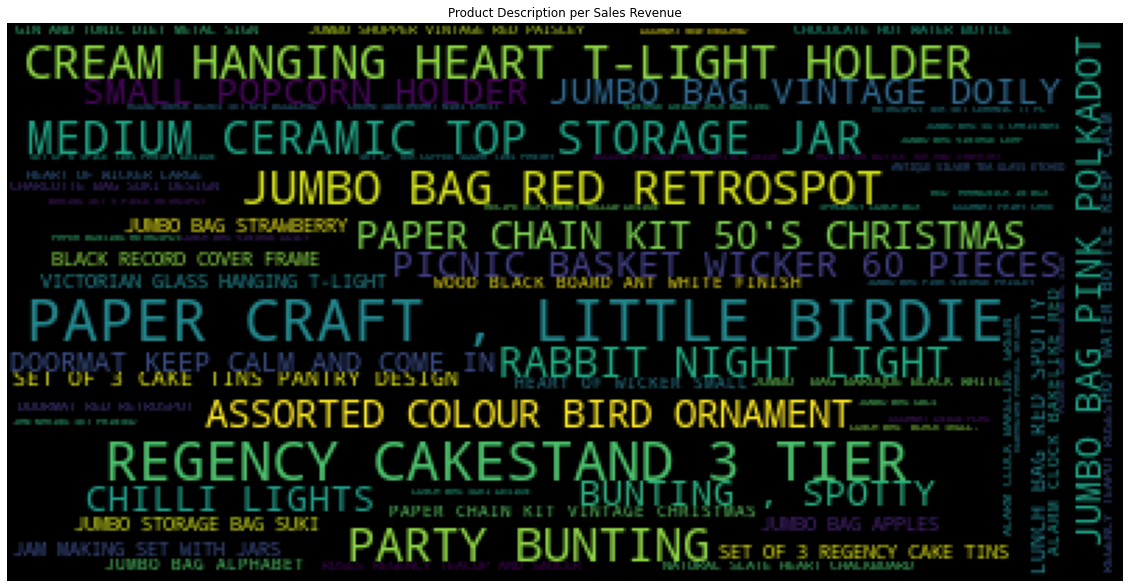

In [70]:
temp_df = pd.DataFrame(df.groupby('Description')['Sales Revenue'].sum()).reset_index()
title = "Product Description per Sales Revenue"
wordcloud_of_Description(temp_df, title)

#### ***Monthly Stats*** 

Below are the monthly analysis of the Sales and the Quantity of iterms sold

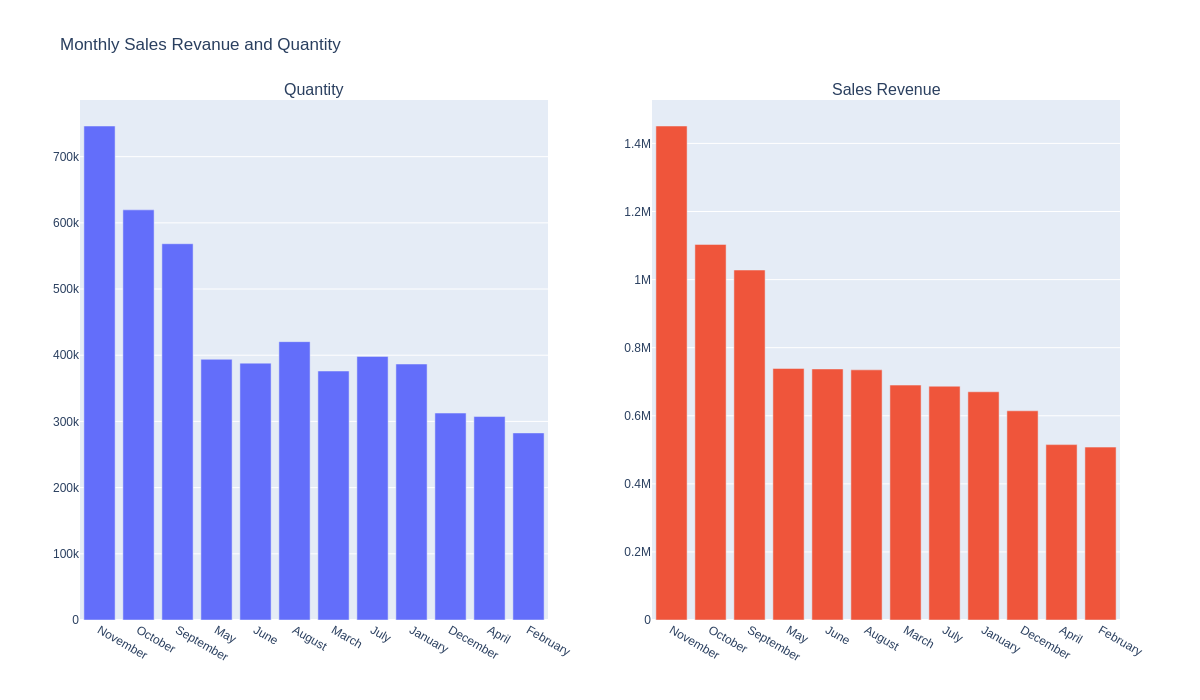

In [71]:
temp_df = group_Quantity_and_SalesRevenue(df,'Month')
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                  )

fig.add_trace(go.Bar(x=temp_df['Month'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Month'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(showlegend=False, title_text="Monthly Sales Revanue and Quantity")
fig.show(renderer='png', height=700, width=1200)
#fig.show( height=700, width=1000)

The above graphs show the monthly trend of Quantity of products ordered(left) and Sales Revenue(right). Both the measures were the highest in Novemeber folllowed by October and Septemeber.

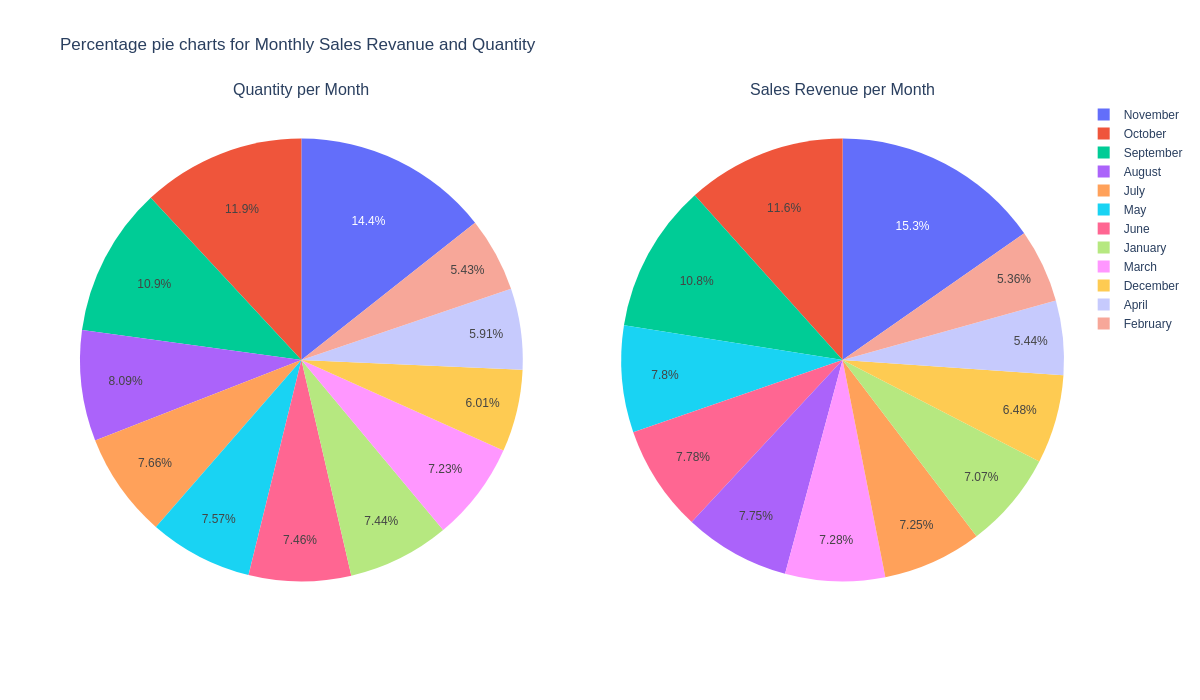

In [72]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity per Month", "Sales Revenue per Month")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Month'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Month'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(title_text="Percentage pie charts for Monthly Sales Revanue and Quantity")

fig.show(renderer='png', height=700, width=1200)
#fig.show( height=700, width=1000)

The above pie charts depicts the quantity of products ordered and sales revenue per month with highest in the month of November with 14.4% and lowest in the month of february with 5.43%.

#### ***Weekly Stats*** 

The below are the weekly analysis of the Sales and the Quantity of iterms sold

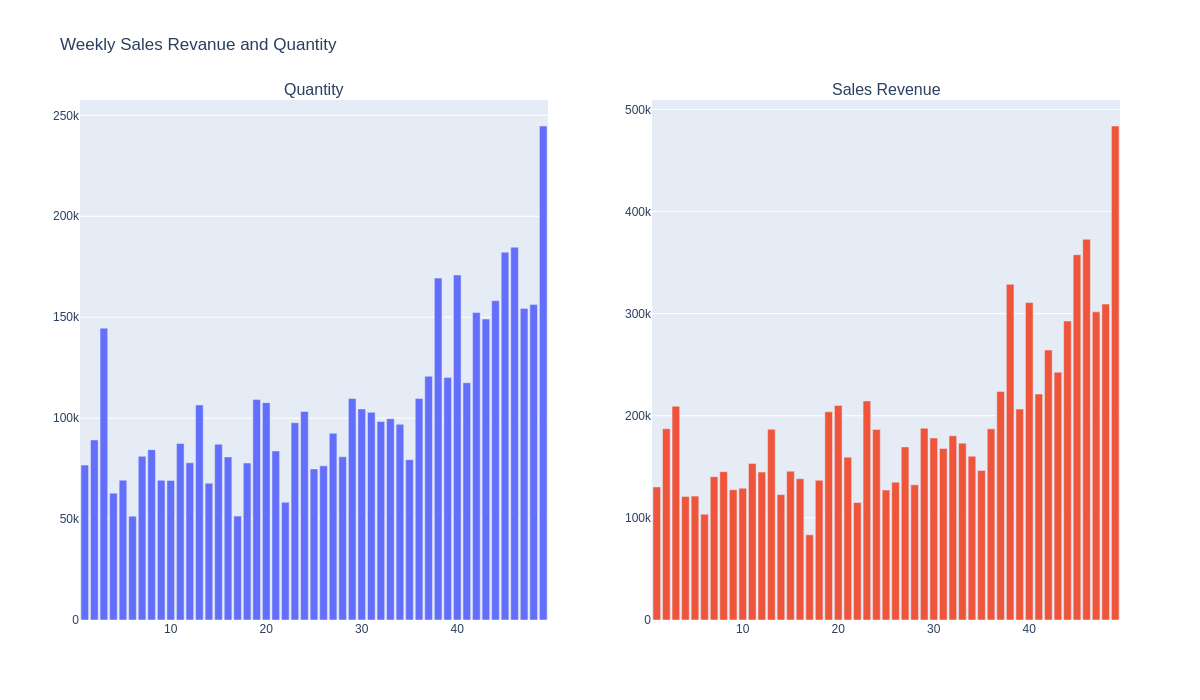

In [73]:
temp_df = group_Quantity_and_SalesRevenue(df,'Week of the Year')
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['Week of the Year'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Week of the Year'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(showlegend=False, title_text="Weekly Sales Revanue and Quantity")
fig.show(renderer='png', height=700, width=1200)
#fig.show( height=700, width=1000)

The above graphs shows the weekly trend of sales revenue and the quantity of products ordered. The highest peak was on the 49th week in the month of November. As it's a holiday season, there was a high demand for the decoration items. As the quantity increases sales revenue too increases.

#### ***Daily Stats*** 

The below are the daily analysis of the Sales and the Quantity of iterms sold

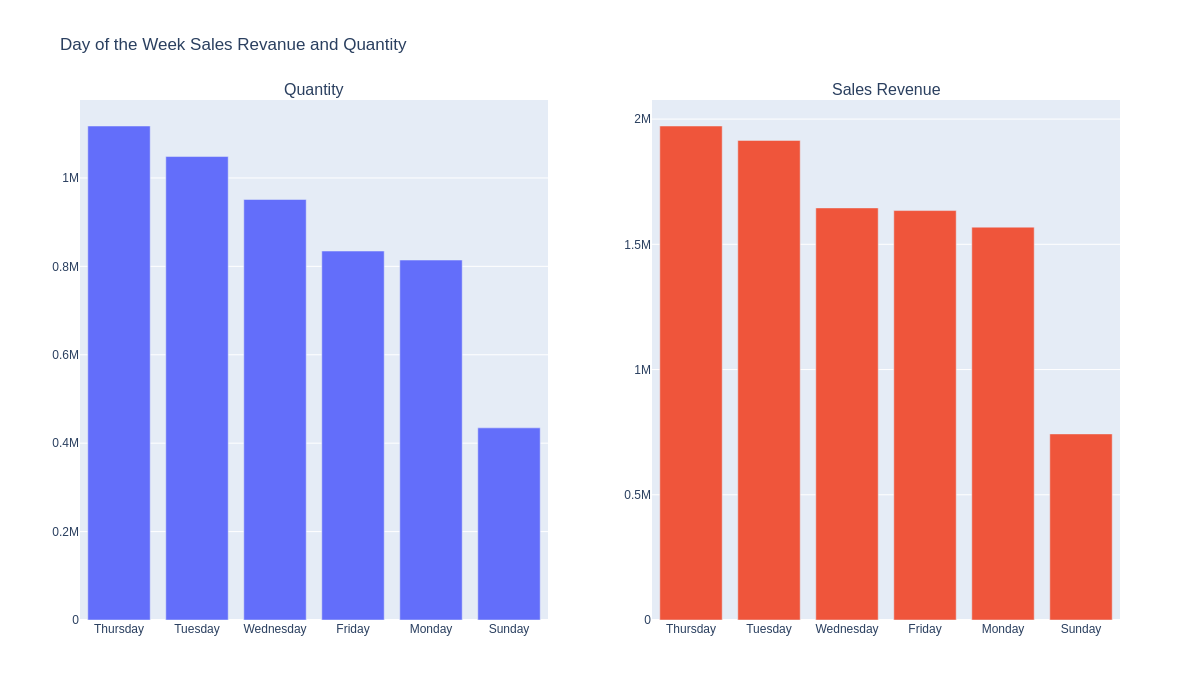

In [74]:
temp_df = group_Quantity_and_SalesRevenue(df,'Day of Week')
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['Day of Week'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Day of Week'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Greys'), showlegend=False, title_text="Day of the Week Sales Revanue and Quantity")
fig.show(renderer='png', height=700, width=1200)
#fig.show( height=700, width=1000)

The above graphs depict the daily trend of Sales revenue and quantity. Thursday was observed to generate the highest quantity of products and Sales Revenue.

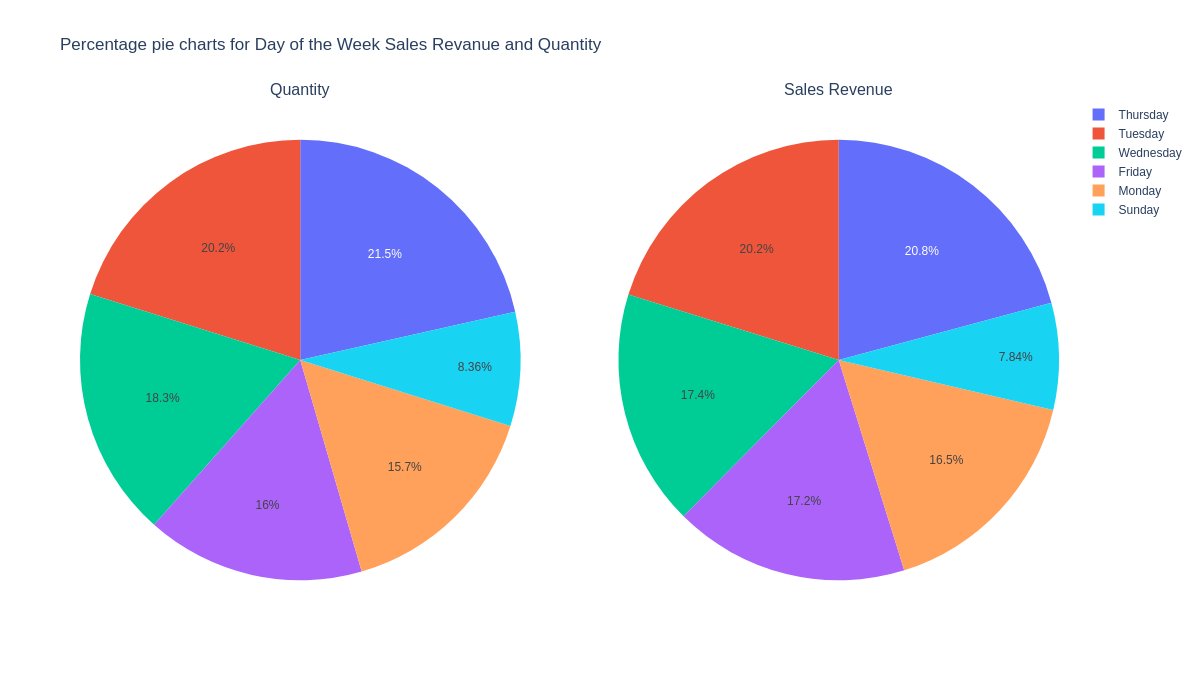

In [75]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity", "Sales Revenue")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Day of Week'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Day of Week'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(title_text="Percentage pie charts for Day of the Week Sales Revanue and Quantity")

fig.show(renderer='png', height=700, width=1200)
#fig.show( height=700, width=1000)

The above pie charts shows the daily trend of sales revenue and quantity of products ordered. 

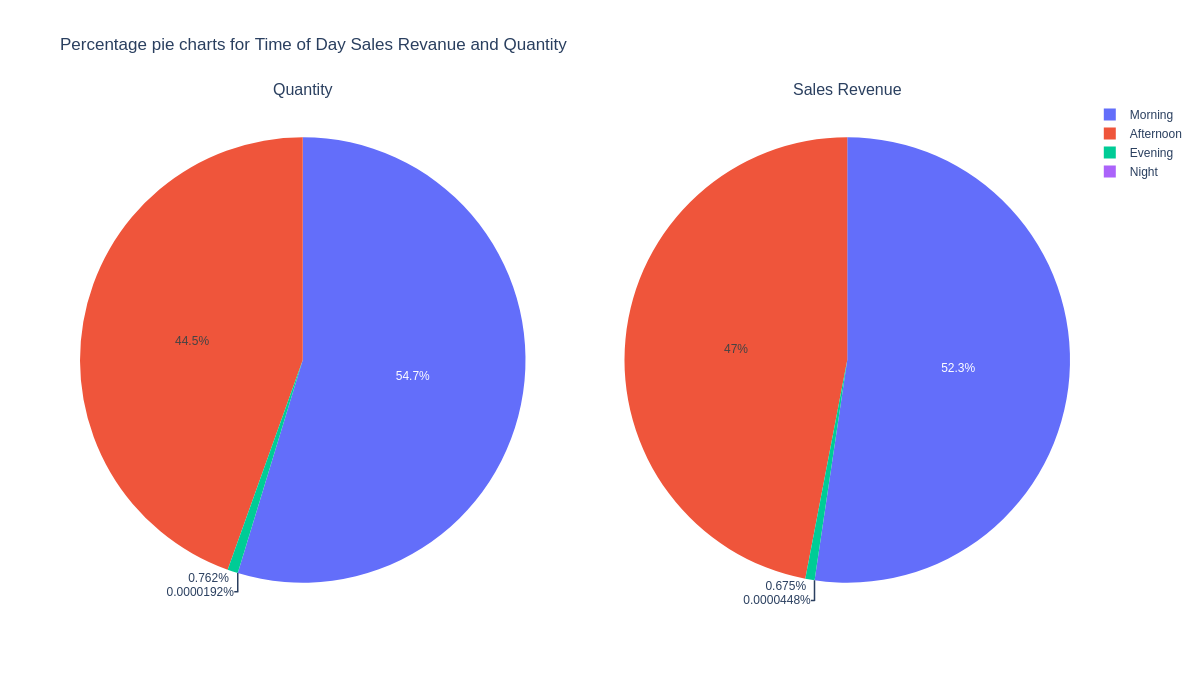

In [76]:
temp_df = group_Quantity_and_SalesRevenue(df,'Time of Day')
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity", "Sales Revenue")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Time of Day'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Time of Day'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(title_text="Percentage pie charts for Time of Day Sales Revanue and Quantity")


fig.show(renderer='png', height=700, width=1200)
#fig.show( height=700, width=1000)

The above piecharts shows the breakdown of Quantity of orders(left) and Sales revenue(right) by time of the day.  More than 99% of the orders were placed during mornings and afternoon.

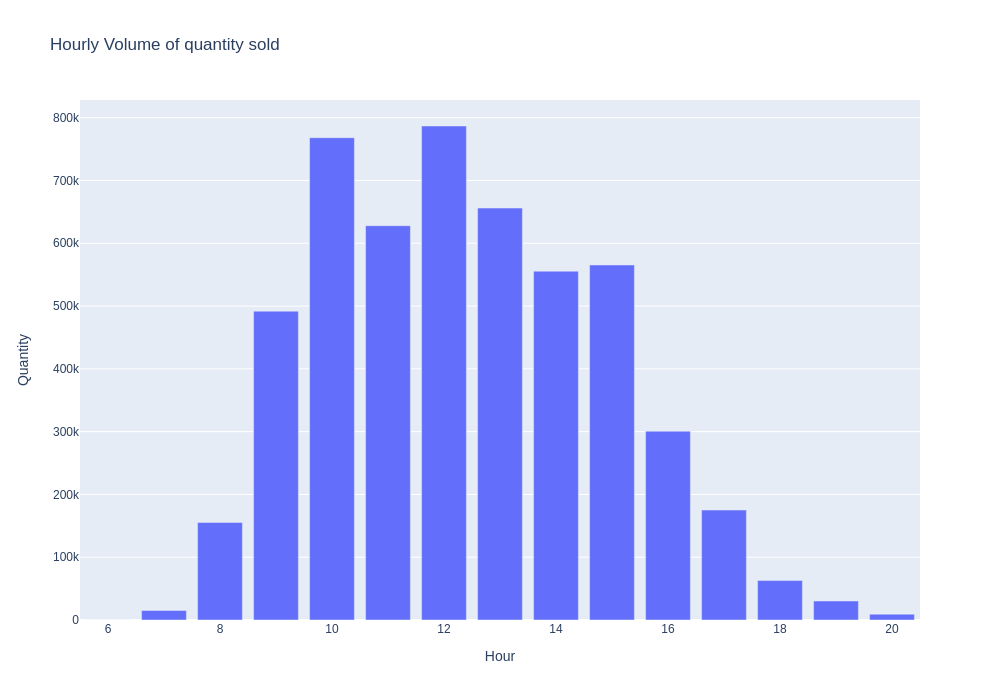

In [77]:
#we can also look at the volume of Invoice Numbers hourly data 
Hourly_Sales = (df.groupby('Hour').sum()["Quantity"]).reset_index()
fig = px.bar(Hourly_Sales, x='Hour', y='Quantity', title='Hourly Volume of quantity sold')
fig.show(renderer='png', height=700, width=1000)
#fig.show(height=700, width=1000)

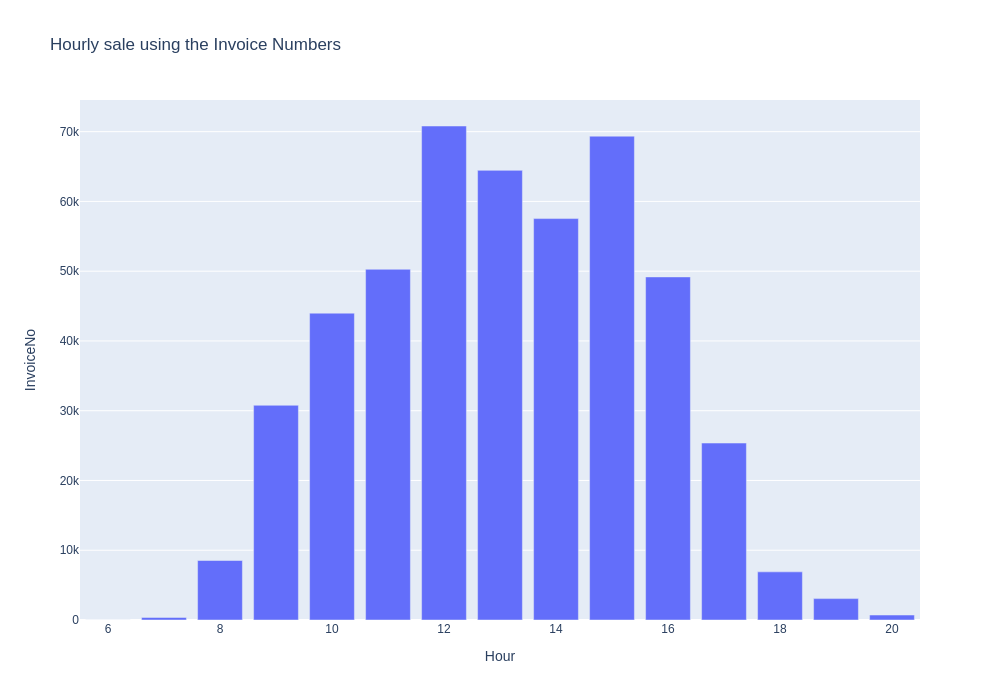

In [78]:
#we can also look at the volume quantity sold hourly data 
Hourly_Sales = (df.groupby('Hour').count()["InvoiceNo"]).reset_index()
fig = px.bar(Hourly_Sales, x='Hour', y='InvoiceNo', title='Hourly sale using the Invoice Numbers')
fig.show(renderer='png', height=700, width=1000)
#fig.show(height=700, width=1000)

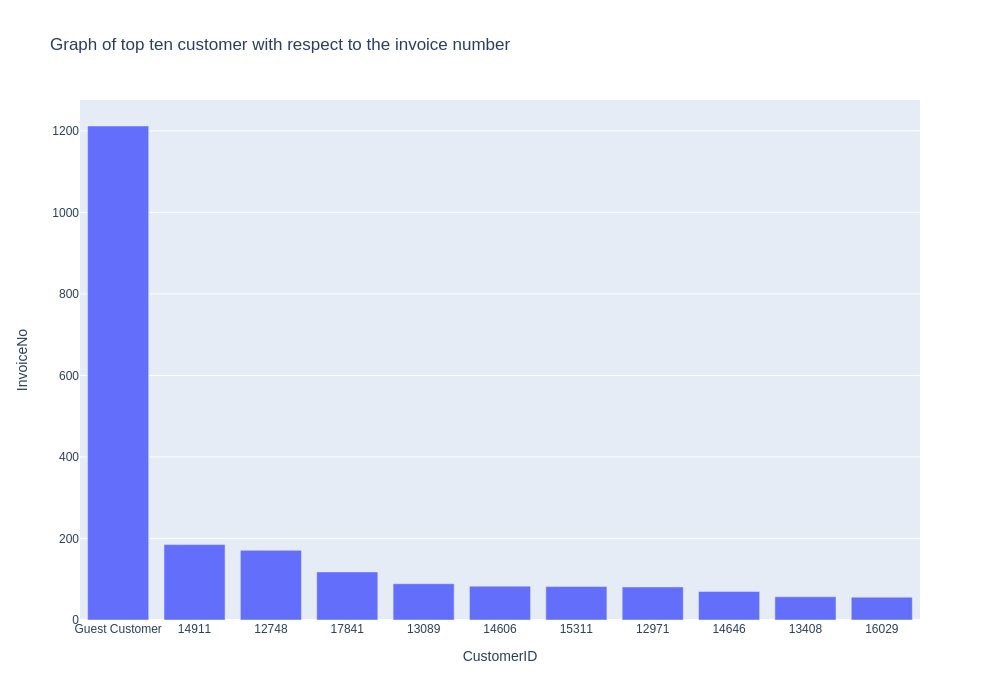

In [79]:
data = df.groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(11)
fig = px.bar(data, x='CustomerID', y='InvoiceNo', title='Graph of top ten customer with respect to the invoice number')
fig.show(renderer='png', height=700, width=1000)
#fig.show(height=700, width=1000)

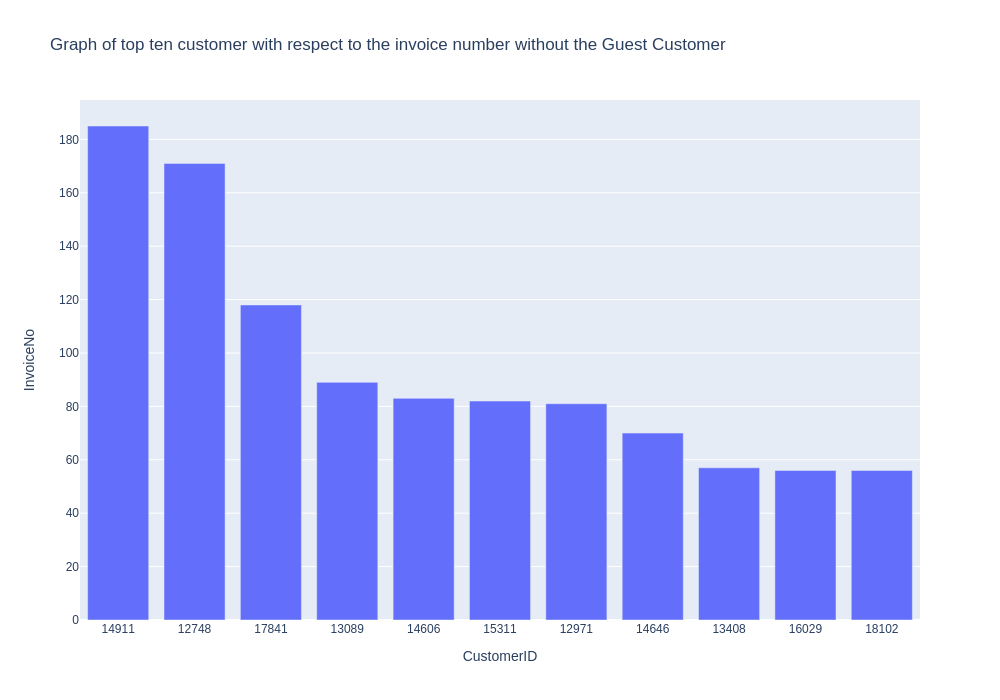

In [80]:
temp_df = df[df["CustomerID"] != "Guest Customer"]
data = temp_df.groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(11)
fig = px.bar(data, x='CustomerID', y='InvoiceNo', title='Graph of top ten customer with respect to the invoice number without the Guest Customer')
fig.show(renderer='png', height=700, width=1000)
#fig.show(height=700, width=1000)

In [81]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Description')
Quantity_tempA = temp_df.sort_values(ascending=False, by = "Quantity").head(10).reset_index(drop=True)
Quantity_tempB = temp_df.sort_values(ascending=False, by = "Quantity").tail(10).reset_index(drop=True)

Quantity_tempA.drop('Sales Revenue', axis=1, inplace=True)
Quantity_tempB.drop('Sales Revenue', axis=1, inplace=True)
display_side_by_side([Quantity_tempA, Quantity_tempB], ['Top 10 Description by Quantity\n', 'Bottom 10 Description by Quantity\n'])

,Description,Quantity
0,"PAPER CRAFT , LITTLE BIRDIE",80995
1,MEDIUM CERAMIC TOP STORAGE JAR,78033
2,SMALL POPCORN HOLDER,54158
3,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49660
4,JUMBO BAG RED RETROSPOT,46220
5,ASSORTED COLOUR BIRD ORNAMENT,33977
6,CREAM HANGING HEART T-LIGHT HOLDER,33889
7,PACK OF 72 RETROSPOT CAKE CASES,32253
8,RABBIT NIGHT LIGHT,30726
9,MINI PAINT SET VINTAGE,23923


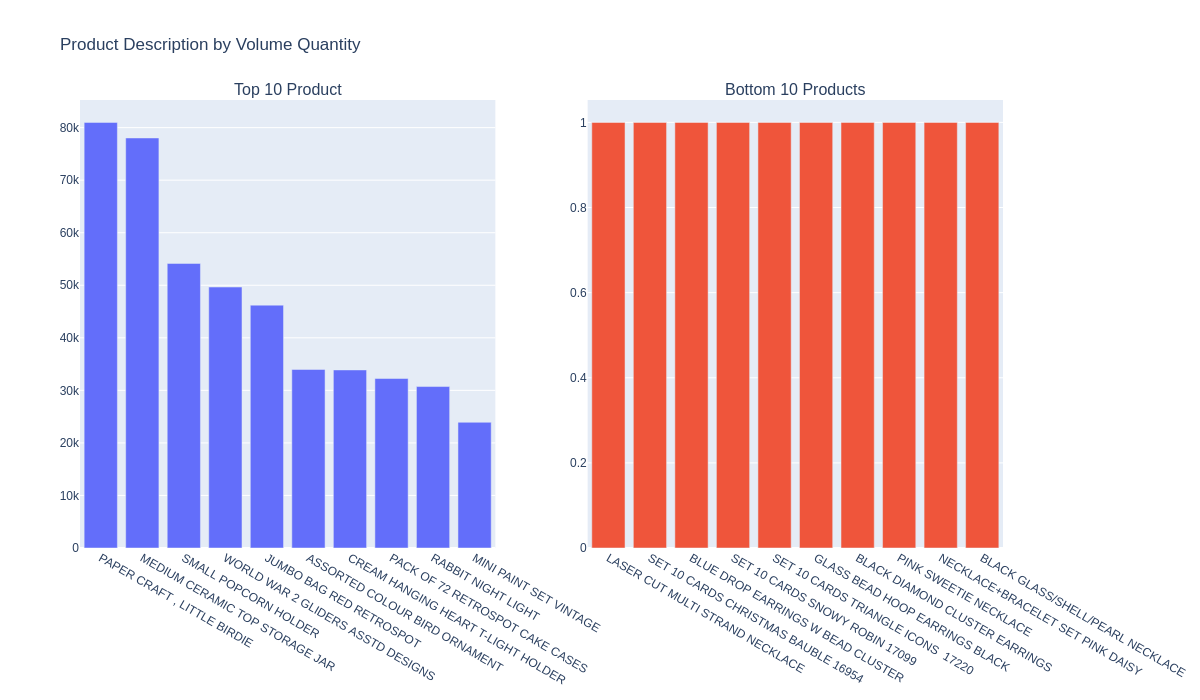

In [82]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Top 10 Product", "Bottom 10 Products")
                        )

fig.add_trace(go.Bar(x=Quantity_tempA['Description'], y=Quantity_tempA['Quantity'],name = 'Top10'),1, 1)

fig.add_trace(go.Bar(x=Quantity_tempB['Description'], y=Quantity_tempB['Quantity'],name = 'Bottom10'),1, 2)

fig.update_layout(showlegend=False, title_text="Product Description by Volume Quantity")
fig.show(renderer='png', height=700, width=1200)
#fig.show(height=700, width=1000)

The above graphs depict the top 10 and bottom 10 products by volume quantity. The product paper craft, little birdie was the most popular item whereas orange/fuschia stones necklace was the least popular item.

In [83]:
Sales_Revenue_tempA = temp_df.sort_values(ascending=False, by = "Sales Revenue").head(10).reset_index(drop=True)
Sales_Revenue_tempB = temp_df.sort_values(ascending=False, by = "Sales Revenue").tail(10).reset_index(drop=True)

Sales_Revenue_tempA.drop('Quantity', axis=1, inplace=True)
Sales_Revenue_tempB.drop('Quantity', axis=1, inplace=True)
display_side_by_side([Sales_Revenue_tempA, Sales_Revenue_tempB], ['Top 10 Description by Sales Revenue\n', 'Bottom 10 Description by Sales Revenue\n'])

,Description,Sales Revenue
0,"PAPER CRAFT , LITTLE BIRDIE",168469.600000
1,REGENCY CAKESTAND 3 TIER,146436.280000
2,PARTY BUNTING,98237.490000
3,CREAM HANGING HEART T-LIGHT HOLDER,94027.390000
4,JUMBO BAG RED RETROSPOT,90140.660000
5,MEDIUM CERAMIC TOP STORAGE JAR,81700.920000
6,RABBIT NIGHT LIGHT,66842.990000
7,PAPER CHAIN KIT 50'S CHRISTMAS,55667.490000
8,ASSORTED COLOUR BIRD ORNAMENT,54918.090000
9,PICNIC BASKET WICKER 60 PIECES,50287.910000


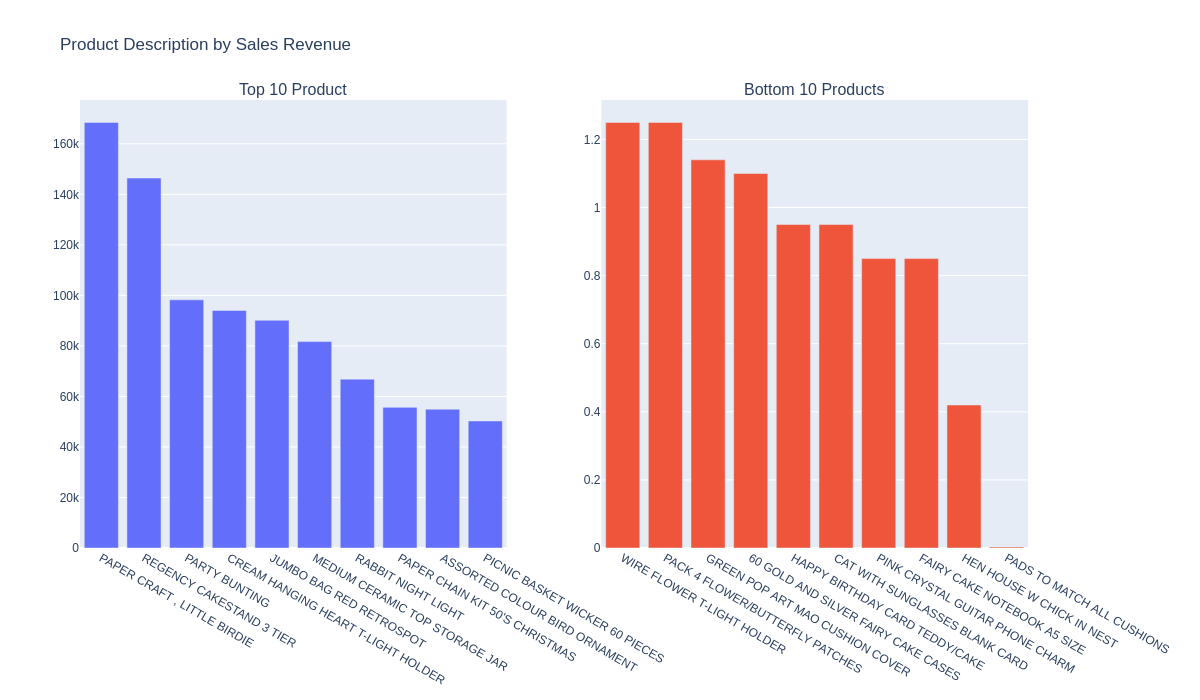

In [84]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Top 10 Product", "Bottom 10 Products")
                        )

fig.add_trace(go.Bar(x=Sales_Revenue_tempA['Description'], y=Sales_Revenue_tempA['Sales Revenue'],name = 'Top10'),1, 1)

fig.add_trace(go.Bar(x=Sales_Revenue_tempB['Description'], y=Sales_Revenue_tempB['Sales Revenue'],name = 'Bottom10'),1, 2)

fig.update_layout(showlegend=False, title_text="Product Description by Sales Revenue")
fig.show(renderer='png', height=700, width=1200)
#fig.show(height=700, width=1000)

The above graphs depict the top 10 and bottom 10 products by sales revenue. The product paper craft, little birdie was found to be generating the highest sales and pads had the lowest sales.

### **Market Basket Analysis**

**What is Market Basket Analysis?:**

Market Basket Analysis (MBA) is a data mining technique that is mostly used in the Retail Industry to uncover customer purchasing patterns and product relationships. The techniques used in MBA identify the patterns, associations, and relationships (revealing product groupings and which products are likely to be purchased together) in in frequently purchased items by customers in large transaction datasets collected/registered at the point of sale. The results of the Market Basket Analysis can be used by retailers or marketers to design and develop marketing and operation strategies for a retail business or organization.<br>
Market basket analysis mainly utilize Association Rules {IF} -> {THEN}. However, MBA assigns Business outcomes and scenarios to the rules, for example,{IF X is bought} -> {THEN Y is also bought}, so X,Y could be sold together. <br>

Definition: **Association Rule**

Let $I$= \{$i_{1},i_{2},\ldots ,i_{n}$\} be an itemset.

Let $D$= \{$t_{1},t_{2},\ldots ,t_{m}$\} be a database of transactions $t$. Where each transaction $t$ is a nonempty itemset such that ${t \subseteq I}$

Each transaction in D has a unique transaction ID and contains a subset of the items in I.

A rule is defined as an implication of the form:
$X\Rightarrow Y$, where ${X,Y\subseteq I}$.

The rule ${X \Rightarrow Y}$ holds in the dataset of transactions $D$ with support $s$, where $s$ is the percentage of transactions in $D$ that contain ${X \cup Y}$ (that is the union of set $X$ and set $Y$, or, both $X$ and $Y$). This is taken as the probability, ${P(X \cup Y)}$. Rule ${X \Rightarrow Y}$ has confidence $c$ in the transaction set $D$, where $c$ is the percentage of transactions in $D$ containing $X$ that also contains $Y$. This is taken to be the conditional probability, like ${P(Y \vert X)}$. That is,

* support${(X \Rightarrow Y)}$ = ${P(X \cup Y)}$

* confidence${(X \Rightarrow Y)}$ = ${P(X \vert Y)}$

The lift of the rule ${(X \Rightarrow Y)}$  is the confidence of the rule divided by the expected confidence, assuming that the itemsets $X$ and $Y$ are independent of each other.The expected confidence is the confidence divided by the frequency of ${Y}$.

* lift${(X \Rightarrow Y)}$ =${\frac {\mathrm {supp} (X\cap Y)}{\mathrm {supp} (X)\times \mathrm {supp} (Y)}}$


Lift value near 1 indicates ${X}$ and ${Y}$ almost often appear together as expected, greater than 1 means they appear together more than expected and less than 1 means they appear less than expected.Greater lift values indicate stronger association

##### **Benefit of MBA**

We are going to make a list of countries, this way a user (either in this notebook or the streamlit tool) can toggle through the countries and do MBA for just that country

In [85]:
country_list = list(dict(df['Country'].value_counts()).keys())
def choose_country(country = "all", data = df):
  """
  This fuction takes in a country name and filters the data frame for just country
  if the there is no country inputed the fuction return the un filtered dataframe
  """
  if country == "all":
    return data
  else:
    temp_df = data[data["Country"] == country]
    temp_df.reset_index(drop= True, inplace= True)

    return temp_df


In [86]:
#we are going to use the UK 
MBA_df = choose_country(country="United Kingdom")
MBA_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Month,Week of the Year,Day of Week,Time,Hour,Time of Day,Sales Revenue
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,19.5
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,12.5


We are going to use the Apriori Algorithm for the association rule mining/analysis. Apriori is an algorithm for frequent item set mining and association rule learning over relational dataset. It proceeds by identifying the frequent individual items in the dataset and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the dataset. The frequent item sets determined by Apriori can be used to determine association rules which highlight general trends, pattern, and relationships in the dataset

In [87]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [88]:
#we are going to rearrage the dataframe having the 'InvoiceNo' column the index, so that each row contains all the items purchased under the same invoice
basket = (MBA_df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

In [89]:
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From the above table we are going to make that very value that is less than or equal to 0 be zero and anything else be equal to 1.
This is called one hot encoding and we will use the buit in pandas `applymap()`function with a custom function as input to check the condition stated above

In [90]:
def encoder(x):
  if(x <= 0):
    return 0
  if(x >= 1):
    return 1

#now we encode
basket = basket.applymap(encoder)
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
#we will filter out transactions that have less than 2 items 
basket = basket[ (basket > 0).sum(axis=1) >= 2]
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The next step will be to generate the frequent itemsets that have a support of at least 10% using the MLxtend Apriori fuction which returns frequent itemsets from a one-hot DataFrame

In [92]:
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.015640,(10 COLOUR SPACEBOY PEN)
1,0.013735,(12 MESSAGE CARDS WITH ENVELOPES)
2,0.018992,(12 PENCIL SMALL TUBE WOODLAND)
3,0.018335,(12 PENCILS SMALL TUBE RED RETROSPOT)
4,0.019255,(12 PENCILS SMALL TUBE SKULL)


We then can look at the rules  of association using the `MLxtend association_rules()` <br>
The function generates a DataFrame of association rules including the metrics 'score', 'confidence', and 'lift'

In [93]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(3 DRAWER ANTIQUE WHITE WOOD CABINET),(CREAM HANGING HEART T-LIGHT HOLDER),0.034107,0.122889,0.010055,0.294798,2.398896,0.005863,1.243772
1,(CREAM HANGING HEART T-LIGHT HOLDER),(3 DRAWER ANTIQUE WHITE WOOD CABINET),0.122889,0.034107,0.010055,0.081818,2.398896,0.005863,1.051963
2,(3 DRAWER ANTIQUE WHITE WOOD CABINET),(WOOD 2 DRAWER CABINET WHITE FINISH),0.034107,0.030558,0.015838,0.464355,15.195877,0.014795,1.809858
3,(WOOD 2 DRAWER CABINET WHITE FINISH),(3 DRAWER ANTIQUE WHITE WOOD CABINET),0.030558,0.034107,0.015838,0.518280,15.195877,0.014795,2.005091
4,(3 DRAWER ANTIQUE WHITE WOOD CABINET),(WOODEN FRAME ANTIQUE WHITE),0.034107,0.055464,0.010777,0.315992,5.697221,0.008886,1.380885


In [94]:
# Sort values based on lift
rules = rules.sort_values("lift",ascending=False).reset_index(drop= True)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(HERB MARKER ROSEMARY, HERB MARKER CHIVES)","(HERB MARKER PARSLEY, HERB MARKER THYME)",0.011172,0.012420,0.010515,0.941176,75.777155,0.010376,16.788855
1,"(HERB MARKER PARSLEY, HERB MARKER THYME)","(HERB MARKER ROSEMARY, HERB MARKER CHIVES)",0.012420,0.011172,0.010515,0.846561,75.777155,0.010376,6.444433
2,"(HERB MARKER THYME, HERB MARKER CHIVES)","(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.011172,0.012617,0.010515,0.941176,74.593137,0.010374,16.785503
3,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)","(HERB MARKER THYME, HERB MARKER CHIVES)",0.012617,0.011172,0.010515,0.833333,74.593137,0.010374,5.932970
4,"(HERB MARKER THYME, HERB MARKER MINT)","(HERB MARKER ROSEMARY, HERB MARKER CHIVES)",0.012157,0.011172,0.010120,0.832432,74.512496,0.009984,5.901072


In [95]:
rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,7832.000000,7832.000000,7832.000000,7832.000000,7832.000000,7832.000000,7832.000000
mean,0.046382,0.046382,0.012865,0.380519,11.456086,0.010826,2.081612
std,0.027038,0.027038,0.003700,0.217812,12.725958,0.003385,2.490409
min,0.010317,0.010317,0.010055,0.081818,1.270131,0.002673,1.029276
25%,0.023658,0.023658,0.010646,0.198198,5.431319,0.009180,1.194660
50%,0.041467,0.041467,0.011632,0.318524,8.331892,0.010102,1.398190
75%,0.064862,0.064862,0.013669,0.535912,12.251398,0.011635,2.041296
max,0.122889,0.122889,0.049090,0.981132,75.777155,0.040465,52.268581


In [96]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7832 entries, 0 to 7831
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         7832 non-null   object 
 1   consequents         7832 non-null   object 
 2   antecedent support  7832 non-null   float64
 3   consequent support  7832 non-null   float64
 4   support             7832 non-null   float64
 5   confidence          7832 non-null   float64
 6   lift                7832 non-null   float64
 7   leverage            7832 non-null   float64
 8   conviction          7832 non-null   float64
dtypes: float64(7), object(2)
memory usage: 550.8+ KB


### **Customer Segmentation**
* RFM (recency, frequency, monetary) Analysis
* Customer Profitability Analysis (CPA)
* Cohort analysis

### **Product recomendation (people who bought this also bought)**